# PCA of Fecal Virome Samples

*Note*: This is copy of the PCA of Sarah's fecal virome datasets, and is so I can remember how to do a PCA in pandas!

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sns
import json
from natsort import natsorted

# Read the data into a dataframe

For the PCA we want the columns to be the loadings we want to explore, and the rows to be the variables that we are explaining. In this case, we want the columns to be the subsystem names, and the rows to be the samples.

In [2]:
df = pd.read_csv(f"sarah/level2_norm_ss_renamed.tsv", delimiter="\t")
df = df.set_index("Unnamed: 0")
# we put a space in front of these names so they sort to the beginning. Don't forget that later!
df2 = df.rename(columns={'SJ3_Bact': ' SJ3_Bact', 'SJ4_Bact': ' SJ4_Bact'})

df = df2.reindex(natsorted(df2.columns), axis=1)
df = df.T
df.head(4)

Unnamed: 0,Amino Acids and Derivatives;,"Amino Acids and Derivatives; Alanine, serine, and glycine","Amino Acids and Derivatives; Arginine; urea cycle, creatine, polyamines",Amino Acids and Derivatives; Aromatic amino acids and derivatives,Amino Acids and Derivatives; Branched-chain amino acids,"Amino Acids and Derivatives; Glutamine, glutamate, aspartate, asparagine; ammonia assimilation",Amino Acids and Derivatives; Histidine Metabolism,"Amino Acids and Derivatives; Lysine, threonine, methionine, and cysteine",Amino Acids and Derivatives; Proline and 4-hydroxyproline,Carbohydrates;,...,"Stress Response, Defense and Virulence; Adhesion","Stress Response, Defense and Virulence; Host-pathogen interactions","Stress Response, Defense and Virulence; Invasion and intracellular resistance","Stress Response, Defense and Virulence; Resistance to antibiotics and toxic compounds","Stress Response, Defense and Virulence; Stress Response","Stress Response, Defense and Virulence; Stress Response: Electrophile toxicity","Stress Response, Defense and Virulence; Stress Response: Heat/cold shock","Stress Response, Defense and Virulence; Stress Response: Osmotic stress","Stress Response, Defense and Virulence; Toxins and superantigens",Sulfur Metabolism;
SJ3_Bact,1075.399163,2823.628278,15257.802835,12034.769290,8741.816842,5826.532505,6192.199005,15832.721523,4647.343128,0.000000,...,11.031051,1.282680,20.779421,27690.89139,5907.384120,6.926474,7037.895780,3389.128428,0.000000,2305.843835
SJ4_Bact,1317.587717,3538.684330,17596.675975,15895.244096,9291.278004,6633.144854,7444.819151,19187.597411,5180.169983,0.627709,...,75.325101,0.313855,161.321258,30441.81841,6562.856372,1.569273,8783.168349,2862.271647,0.313855,2858.654846
SJ3_B_Na_22_1,537.312922,6762.094703,11336.371759,6454.552133,4398.567998,3931.264847,5392.614144,20188.859508,6236.356493,0.000000,...,38.418194,0.591049,40.782391,22820.70282,3371.245786,0.591049,6715.549583,1940.850577,0.000000,1224.463838
SJ3_B_Na_22_1.1,532.456165,6864.265989,10780.786809,6314.671252,3936.944285,3718.611116,5260.399119,18733.479656,6337.790472,2.142322,...,32.134823,2.142322,41.775270,24184.13223,3370.764409,1.071161,7692.094735,2013.858755,0.000000,1160.245638


## Create some new labels

Here I used [named groups](https://docs.python.org/3/howto/regex.html#non-capturing-and-named-groups) to create a regular expression with variable names that we can access later. The basic syntax is `(?P<Name>...)` for the named group, so we split the abbreviation (e.g. SJ3_B_Qi_22_2) into its component parts, the Sample (SJ3), the approach (B|I|A), the Method (No|Na|Qi|Ma), the filter size (22|45) and the repeat (1|2|3).

We make columns for each of those, and then we set the column names for the two bacterial samples

In [3]:
pattern = r'(?P<Sample>SJ\d)_(?P<Approach>\w+)_(?P<Method>\w+)_(?P<Filter>\d+)_(?P<Rpt>\d+)'
tmp = df.index.str.extract(pattern)
cols = ['Sample', 'Approach', 'Method', 'Filter', 'Rpt']
labels = pd.DataFrame()
labels[cols] = tmp[cols].values
labels.at[0, 'Sample'] = 'SJ3_Bact'
labels.at[0, 'Approach'] = 'SJ3_Bact'
labels.at[0, 'Method'] = 'SJ3_Bact'
labels.at[0, 'Filter'] = 'SJ3_Bact'
labels.at[0, 'Rpt'] = 'SJ3_Bact'
labels.at[1, 'Sample'] = 'SJ4_Bact'
labels.at[1, 'Approach'] = 'SJ4_Bact'
labels.at[1, 'Method'] = 'SJ4_Bact'
labels.at[1, 'Filter'] = 'SJ4_Bact'
labels.at[1, 'Rpt'] = 'SJ4_Bact'
labels.head(10)

,Sample,Approach,Method,Filter,Rpt
0,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact
1,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact
2,SJ3,B,Na,22,1
3,SJ3,B,Na,22,1
4,SJ3,B,Na,45,1
5,SJ3,B,Na,45,2
6,SJ3,B,Na,45,3
7,SJ3,B,No,22,1
8,SJ3,B,No,22,2
9,SJ3,B,No,22,3


# Standardise the data

In [4]:
scaler = StandardScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)
df_scaled

array([[ 1.21438637, -1.76635556,  1.75715022, ...,  3.01914846,
        -0.25482816,  0.87346201],
       [ 2.11773541, -1.41744145,  3.04193393, ...,  2.00400699,
        -0.23925354,  1.49741493],
       [-0.79264361,  0.15543294, -0.39696009, ...,  0.22862367,
        -0.25482816, -0.34708207],
       ...,
       [-0.5274399 ,  0.71746703, -0.03340248, ..., -0.96535275,
        -0.25482816, -0.49591197],
       [-0.38698355,  0.68086032,  0.1679763 , ..., -0.65788546,
        -0.15506545, -0.44679908],
       [-0.13654728,  0.76629766,  0.68990986, ..., -0.56309085,
        -0.25482816, -0.38571848]])

## Run the PCA with 4 components

In [5]:
pca = PCA(n_components=4)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

In [6]:
zipped = list(zip(df_pca[:,0],
                  df_pca[:,1],
                  df_pca[:,2],
                  df_pca[:,3],
                  df.index))
pc_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', 'PC3', 'PC4', "Label"])
pc_df = pd.concat([pc_df, labels], axis=1)
pc_df.head(4)

                     

,PC1,PC2,PC3,PC4,Label,Sample,Approach,Method,Filter,Rpt
0,10.572713,4.857448,-4.966970,-8.268677,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact,SJ3_Bact
1,14.179309,0.118877,-3.950573,-9.706136,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact,SJ4_Bact
2,-4.715552,3.028237,-2.812988,0.626631,SJ3_B_Na_22_1,SJ3,B,Na,22,1
3,-5.404492,4.159004,-2.111670,0.997378,SJ3_B_Na_22_1.1,SJ3,B,Na,22,1


## Make an initial plot to see what the data looks like

We just plot the first two components and label by the complete label for now.

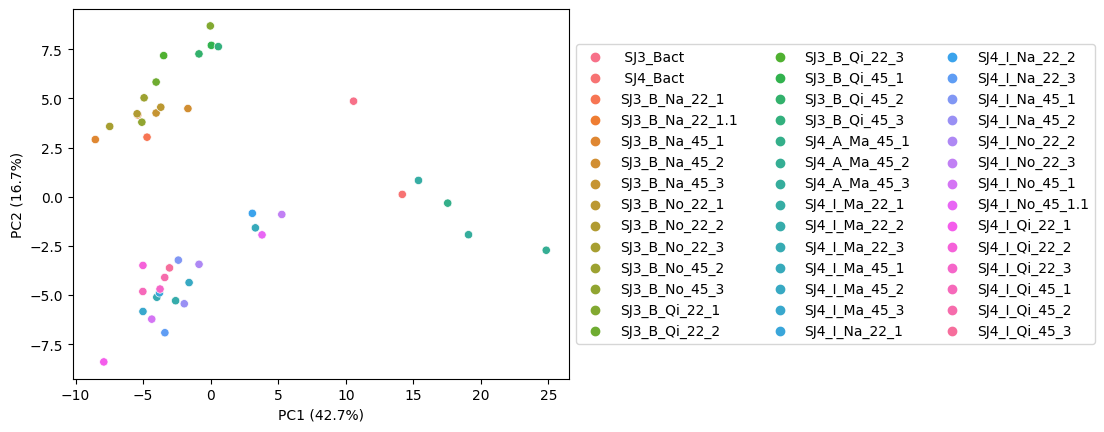

In [7]:
ax = sns.scatterplot(x="PC1", y="PC2", hue='Label', data=pc_df)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
l = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)

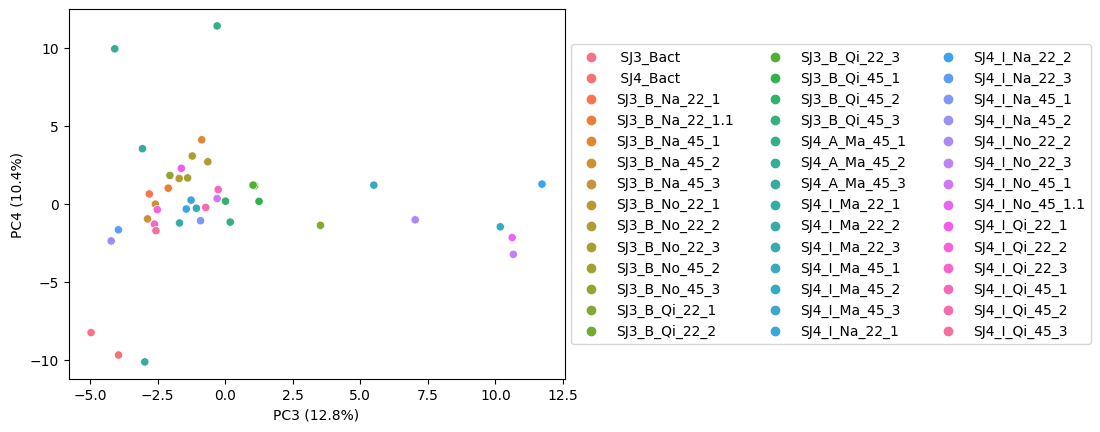

In [8]:
ax = sns.scatterplot(x="PC3", y="PC4", hue='Label', data=pc_df)
l = ax.set_xlabel(f"PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)")
l = ax.set_ylabel(f"PC4 ({pca.explained_variance_ratio_[3]*100:.1f}%)")
l = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)

# Loadings

Lets get the loadings for the PCA, and then we can add them to this plot to see what they look like!

In [9]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df.columns)
loadings.head(3)

,PC1,PC2,PC3,PC4
Unnamed: 0,,,,
Amino Acids and Derivatives;,0.117146,-0.054020,0.045279,-0.056772
"Amino Acids and Derivatives; Alanine, serine, and glycine",-0.091302,-0.128110,-0.051428,0.029349
"Amino Acids and Derivatives; Arginine; urea cycle, creatine, polyamines",0.083936,-0.068726,-0.129345,-0.092973


## To add the loadings to the figure:

1. We use `nlargest` to get the 5 largest loadings from the PCA (most important, presumably). However, we need to do the largest absolute value, but we need the actual values (not the `abs()`) for the plot, so we use the indices to get those values: `loadings.loc[loadings.abs().nlargest(10, ['PC1', 'PC2']).index]`
2. Note you can change the 10 here to plot different numbers of loadings, and the PC1, PC2, etc to change the weights.
3. We figure out the maximum X and Y values for the loadings (mlx, mly) and the PCA (mpx, mpy)
4. We scale the loading value to make the maximum line ~1/2 of the total image. This is a bit random and you can change the `ex = ` and `ey = ` lines as you like. (e.g. just multiply by 10 or something)


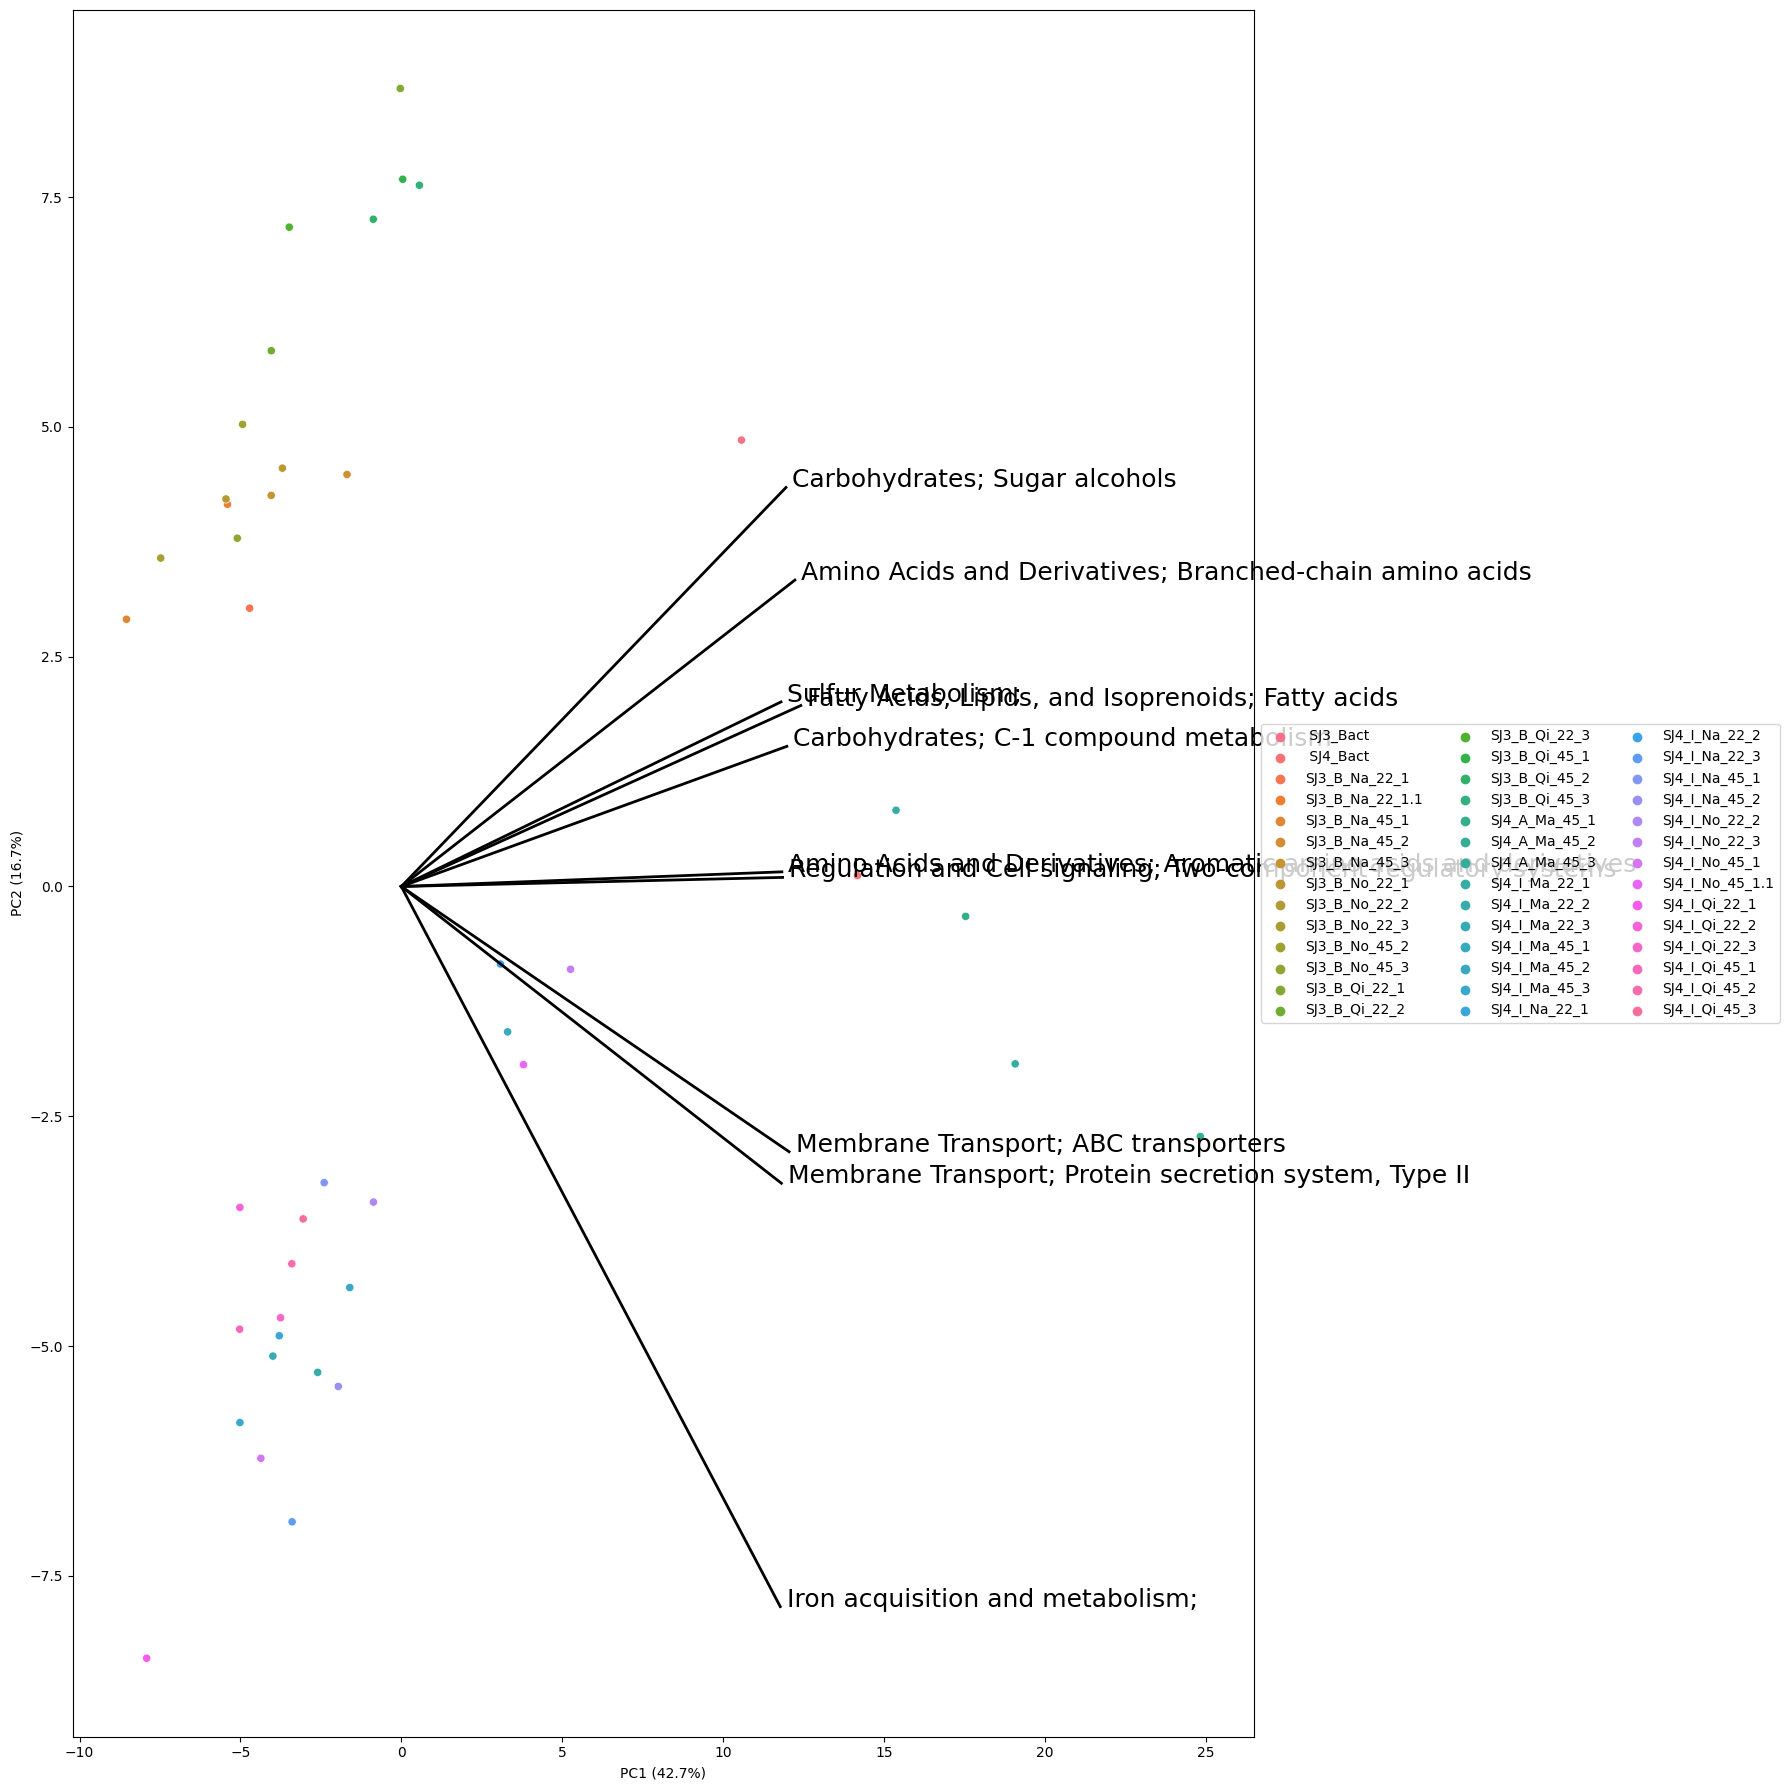

In [10]:
fig, ax = plt.subplots(figsize=(18, 18))
sns.scatterplot(x="PC1", y="PC2", hue='Label', legend=True, data=pc_df, ax=ax)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
# get the 5 largest loadings
ldf = loadings.loc[loadings.abs().nlargest(10, ['PC1', 'PC2']).index]
# get the maximum values for x and y for the loadings and the PCA
mlx = max(ldf.PC1)
mly = max(ldf.PC2)
mpx = max(pc_df.PC1)
mpy = max(pc_df.PC2)

for i, l in ldf.iterrows():
    # scale the loadings to fit the figure
    ex = ( l.PC1 * (mpx/mlx) ) / 2
    ey = ( l.PC2 * (mpy/mly) ) / 2
    # add the text and the line
    plt.text(ex+0.2, ey, i, fontsize=18)
    plt.plot([0, ex ], [0, ey ], 'k-', lw=2)

plt.tight_layout()

# Colour the PCA by different components of the experiment

In this series of figures I leave the loadings off, because we are just interested in the similarities and differences between the samples, not the reason why they are similar and different!

I colour each image by a different value

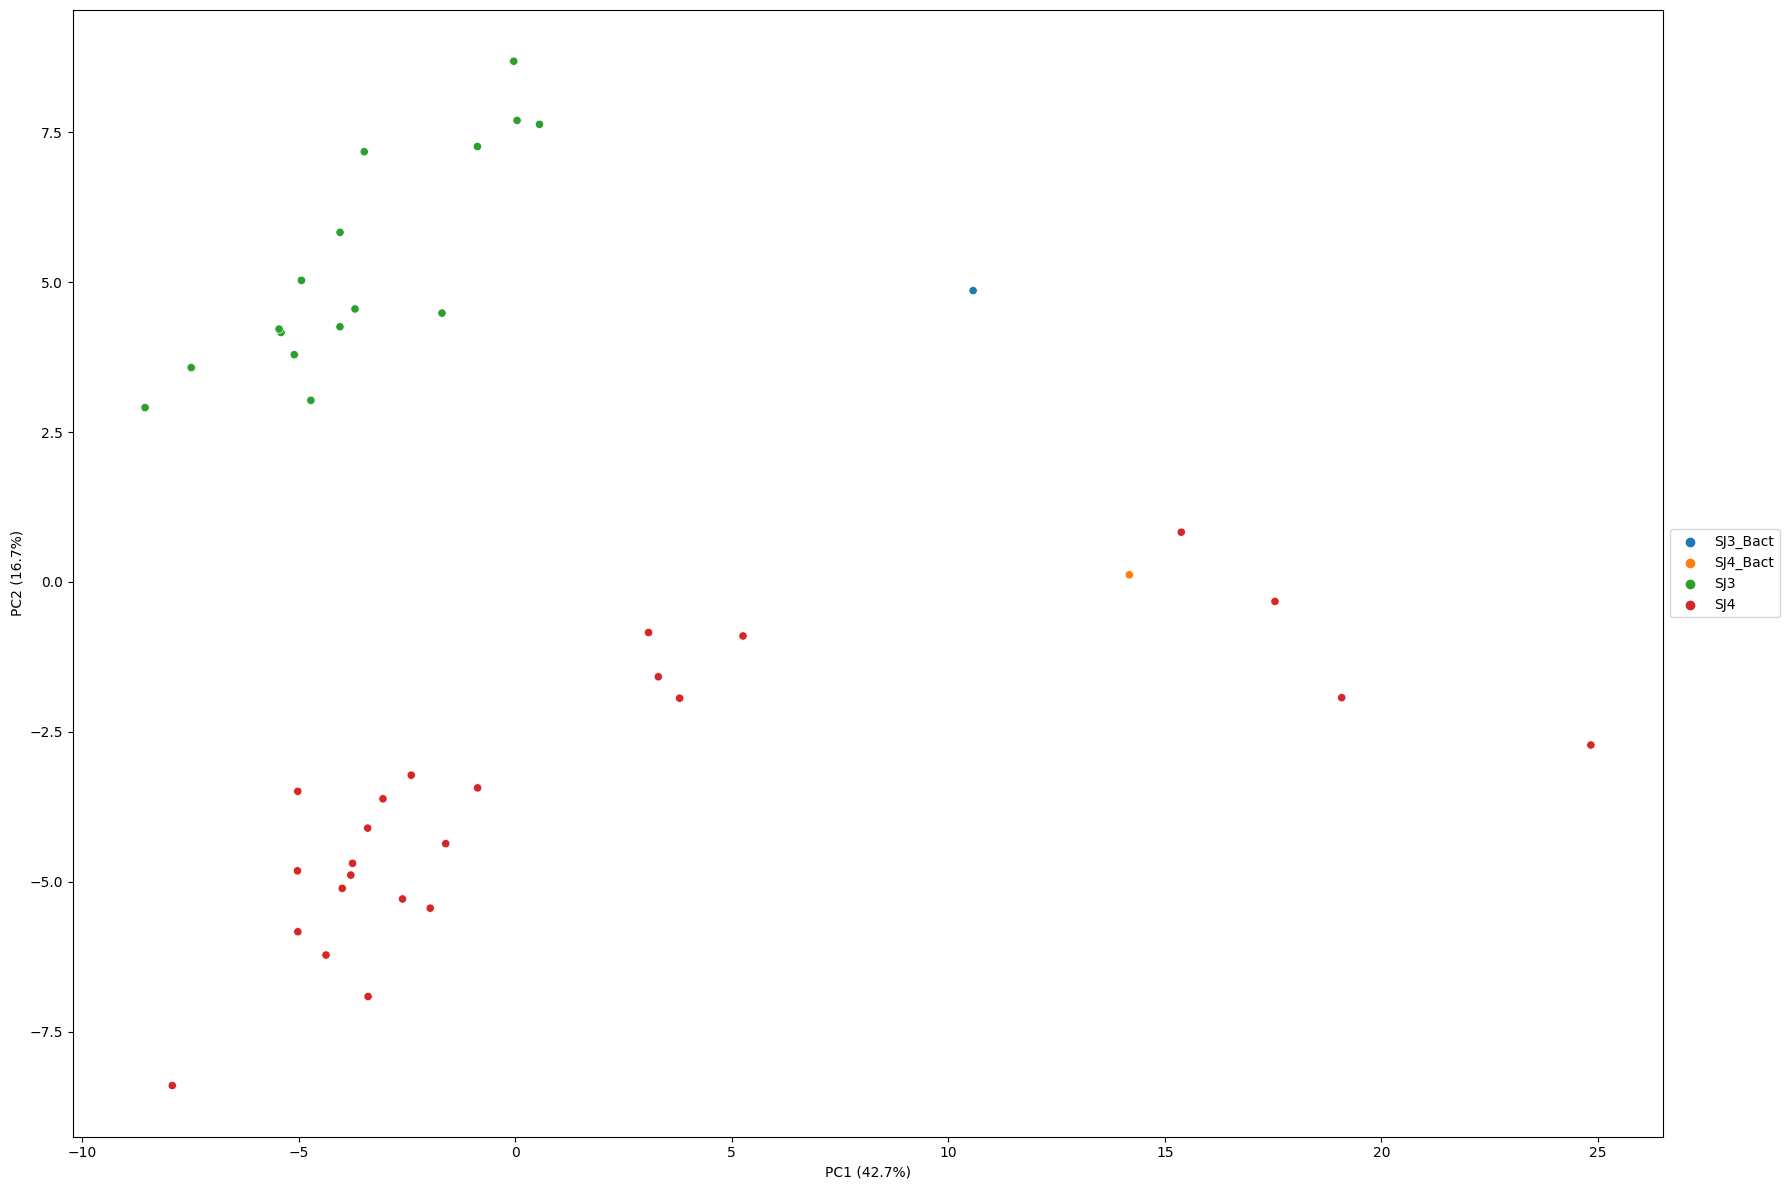

In [11]:
fig, ax = plt.subplots(figsize=(18, 12))
sns.scatterplot(x="PC1", y="PC2", hue='Sample', legend=True, data=pc_df, ax=ax)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
fig.savefig(f"sarah/pca_by_sample.png")

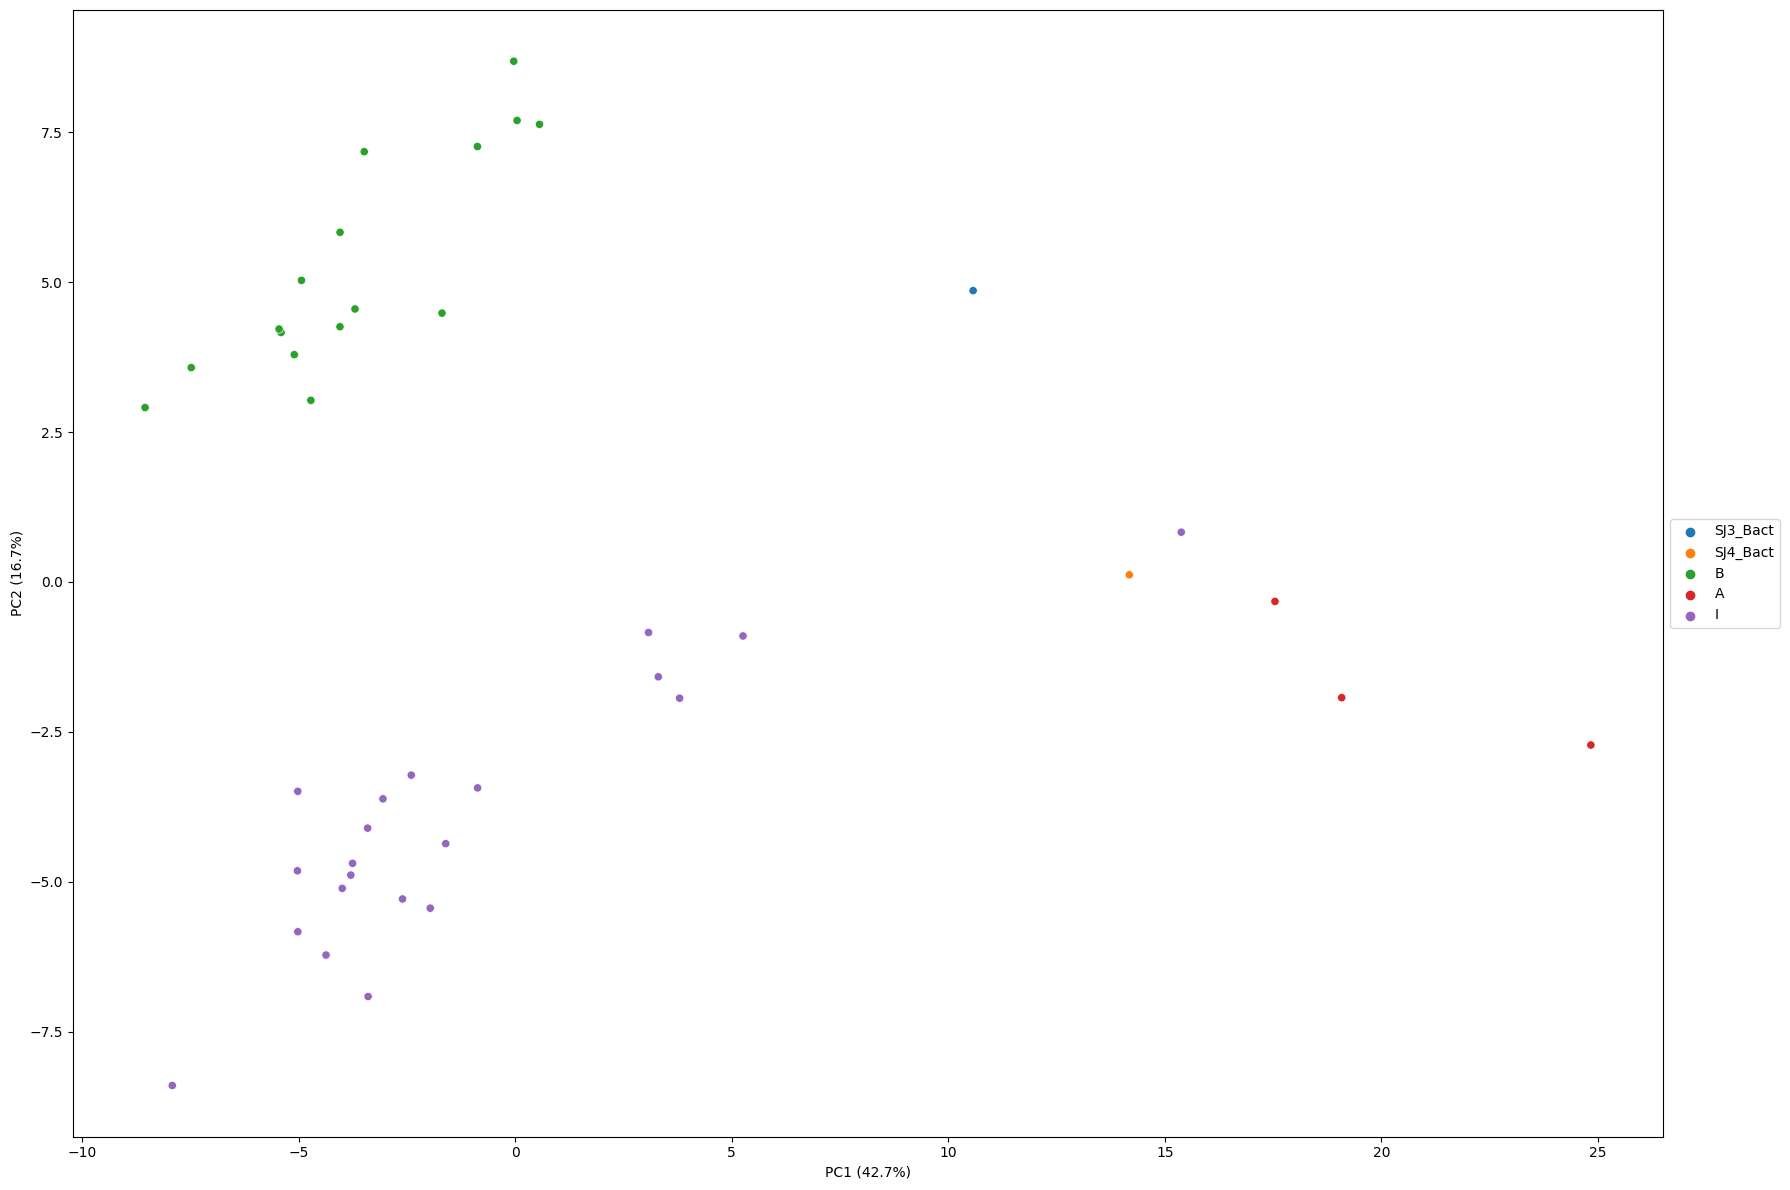

In [12]:
fig, ax = plt.subplots(figsize=(18, 12))
sns.scatterplot(x="PC1", y="PC2", hue='Approach', legend=True, data=pc_df, ax=ax)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
fig.savefig(f"sarah/pca_by_approach.png")

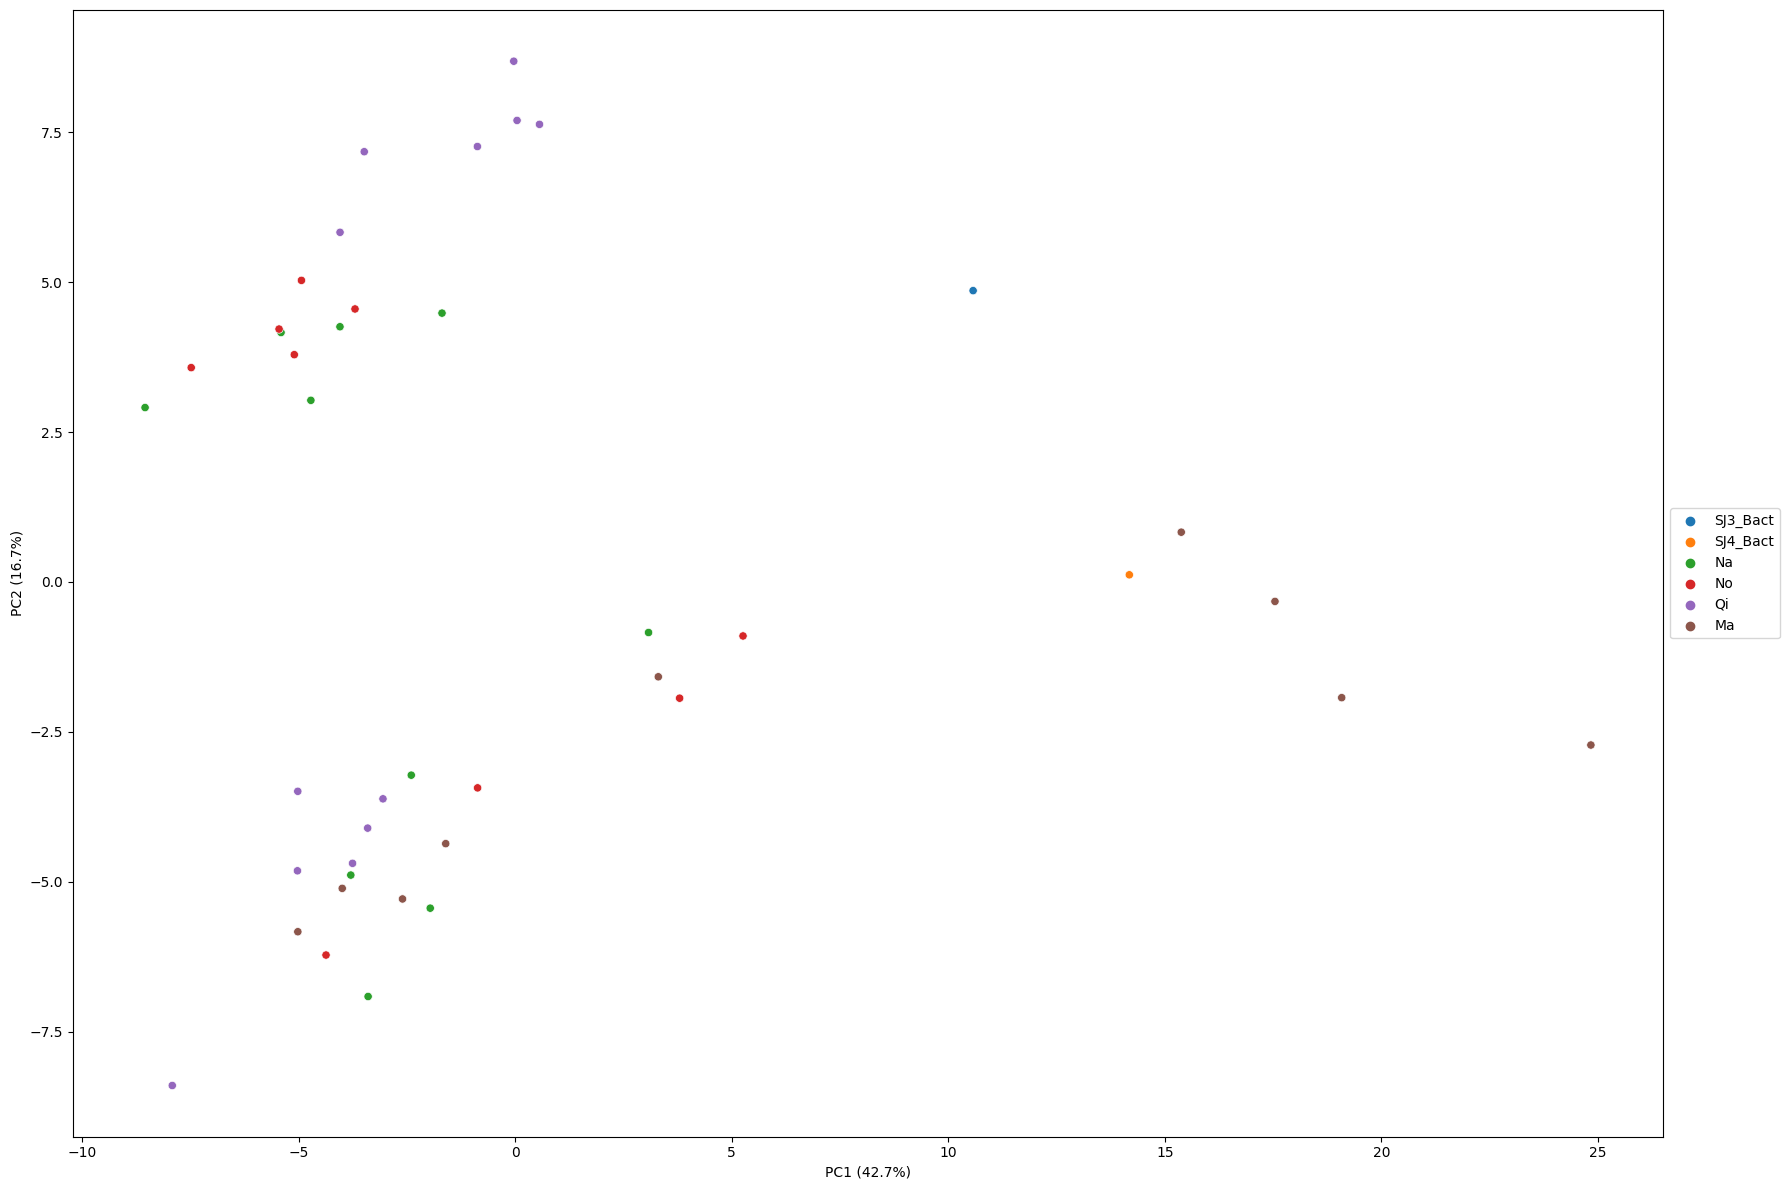

In [13]:
fig, ax = plt.subplots(figsize=(18, 12))
sns.scatterplot(x="PC1", y="PC2", hue='Method', legend=True, data=pc_df, ax=ax)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
fig.savefig(f"sarah/pca_by_method.png")

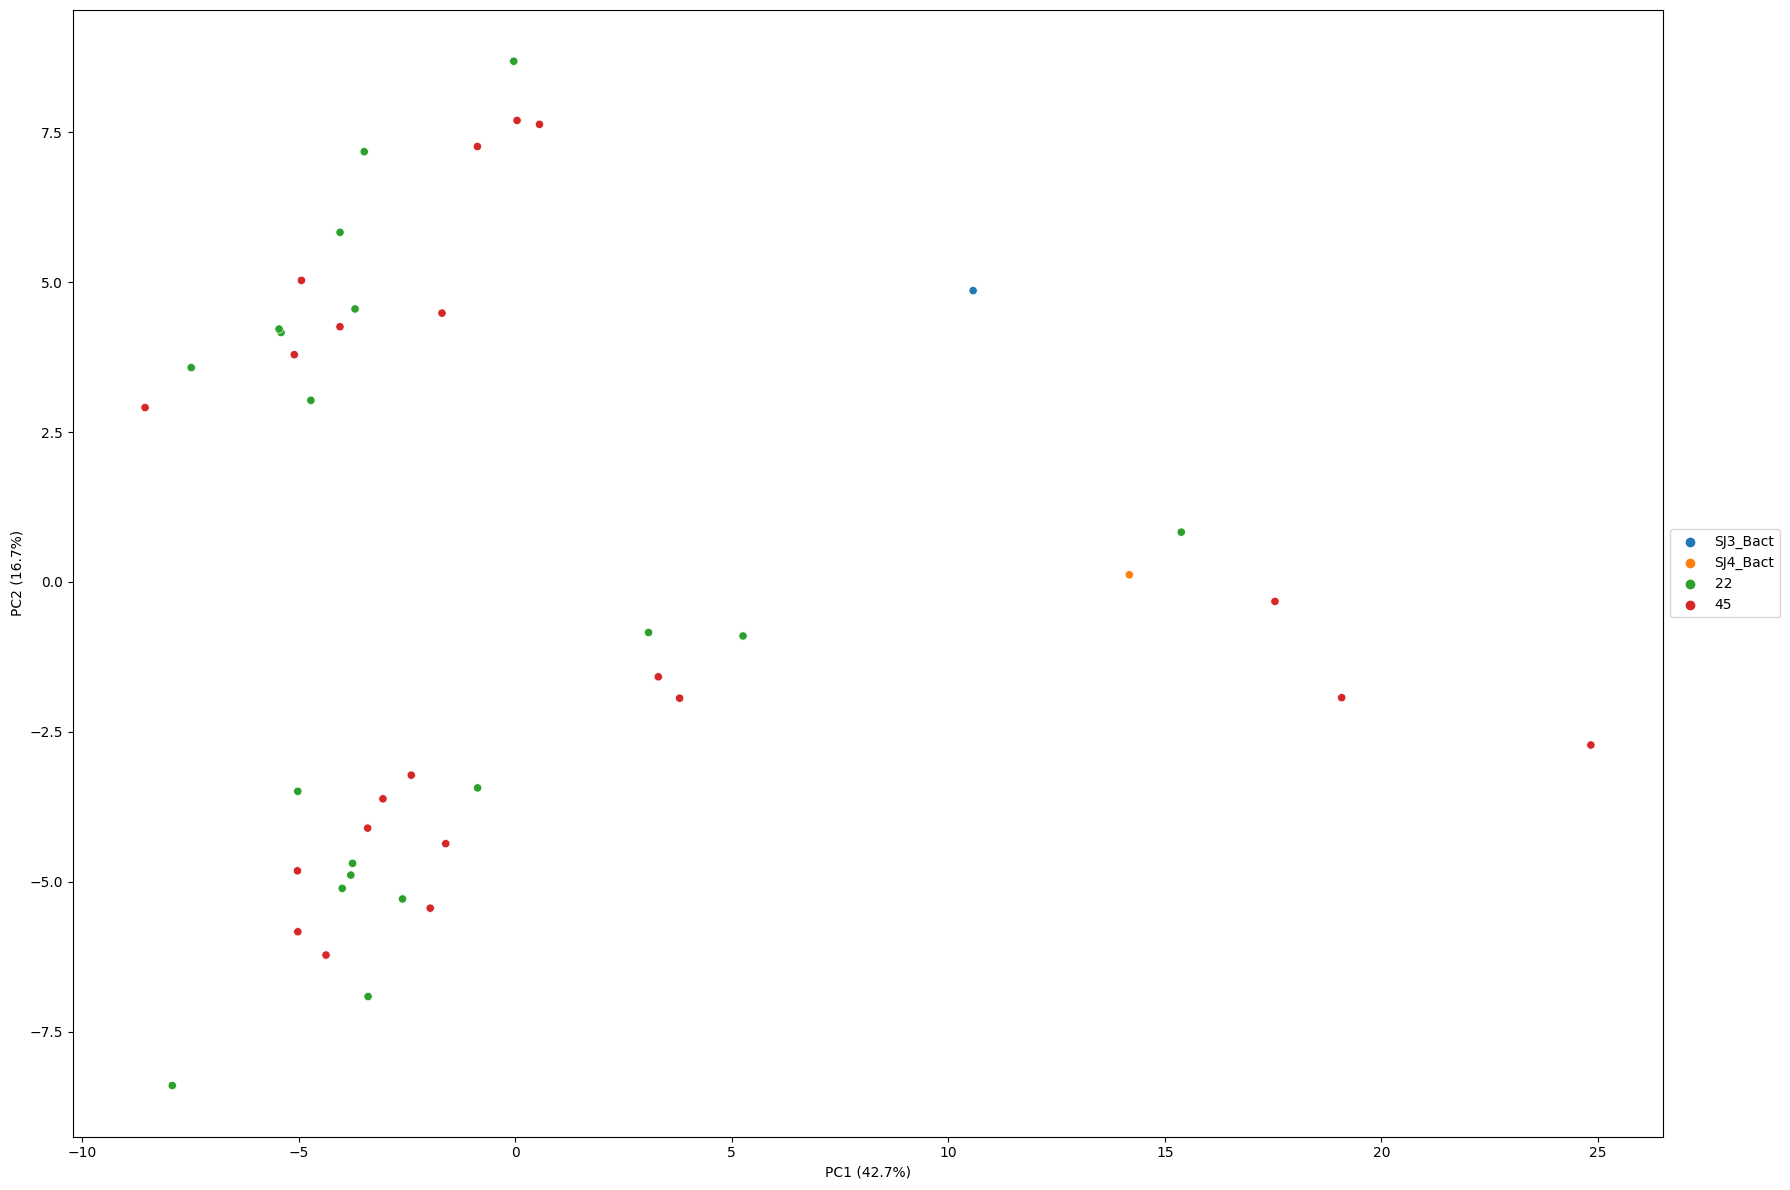

In [14]:
fig, ax = plt.subplots(figsize=(18, 12))
sns.scatterplot(x="PC1", y="PC2", hue='Filter', legend=True, data=pc_df, ax=ax)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
fig.savefig(f"sarah/pca_by_filter.png")

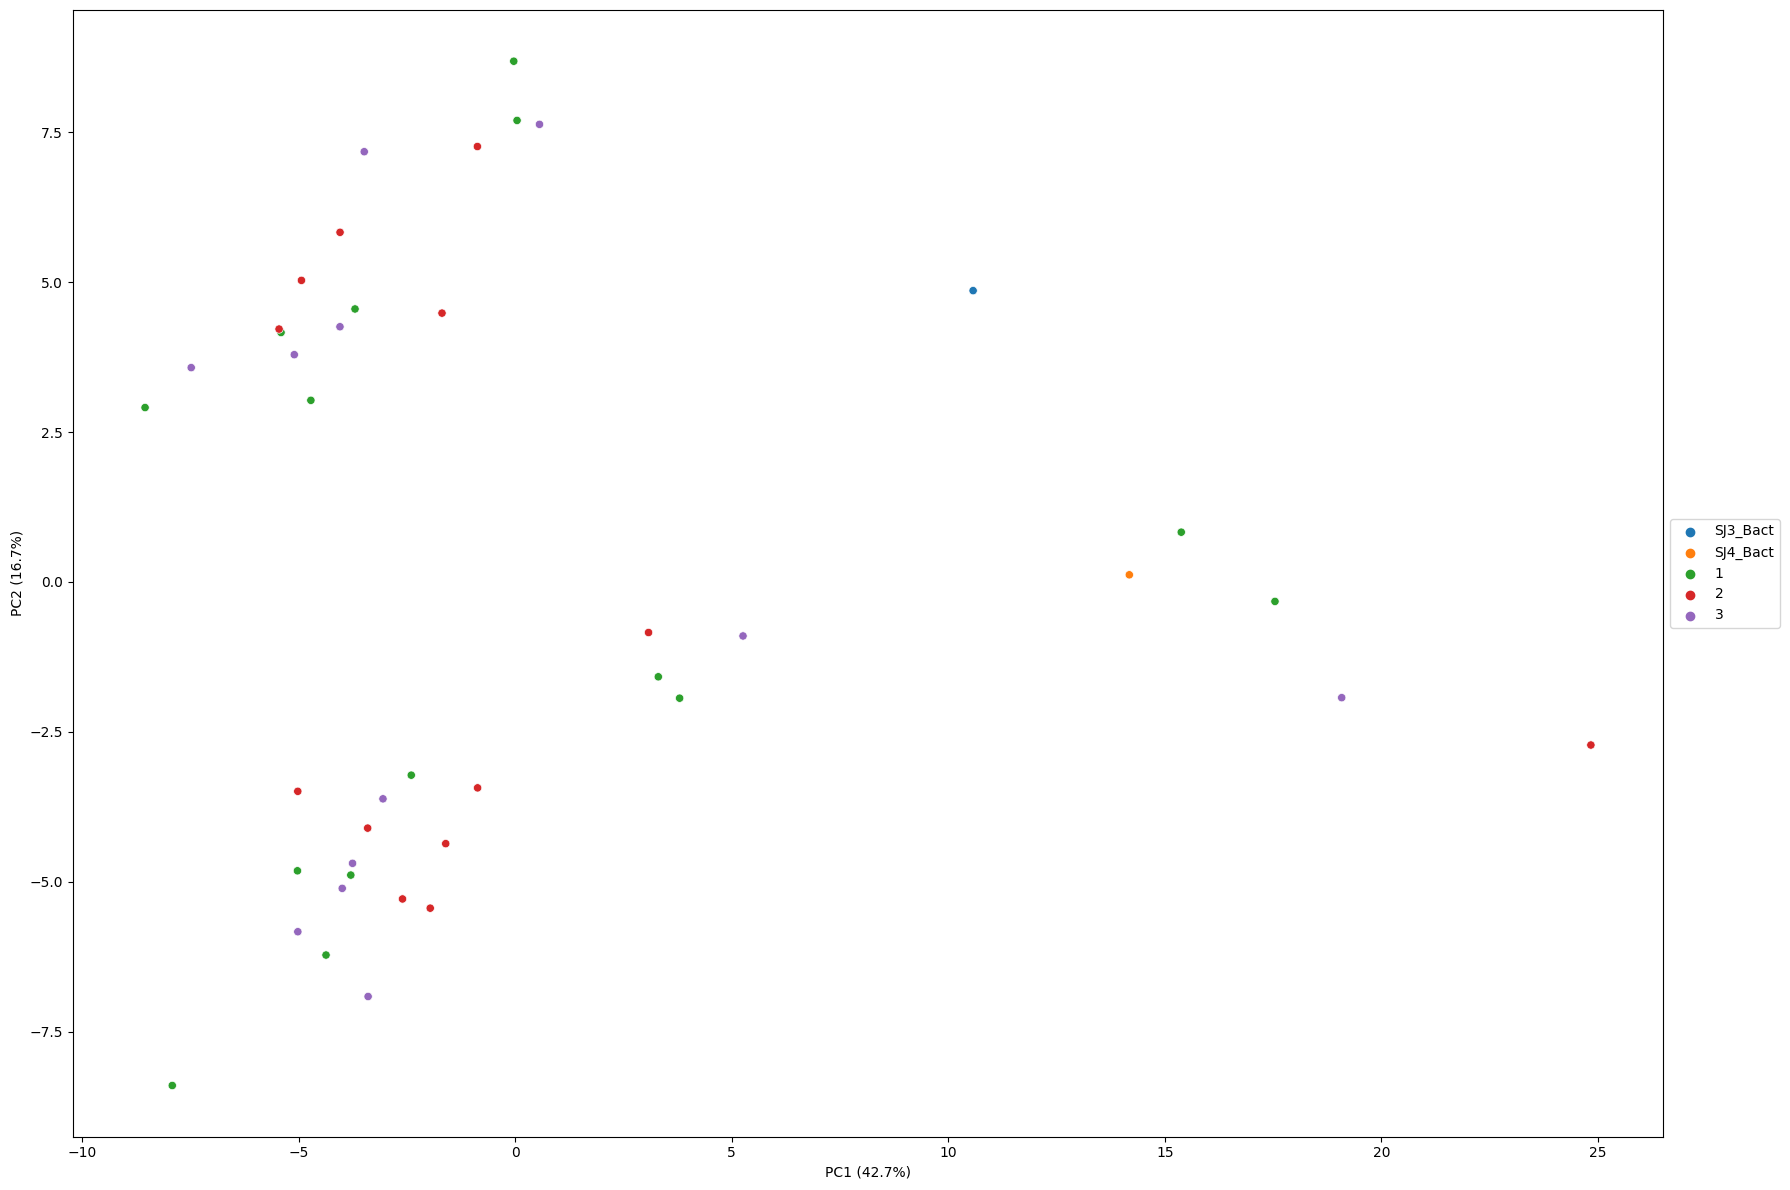

In [15]:
fig, ax = plt.subplots(figsize=(18, 12))
sns.scatterplot(x="PC1", y="PC2", hue='Rpt', legend=True, data=pc_df, ax=ax)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
fig.savefig(f"sarah/pca_by_replicate.png")

## Colour so all the samples are the same

In this image, we combine Sample, Approach, Method, and Filter so that we have 2 or 3 points per sample to see whether the replicates are close to each other or not. To clarify the results, I also change the marker, so now each group of replicates has the same colour and the same marker.

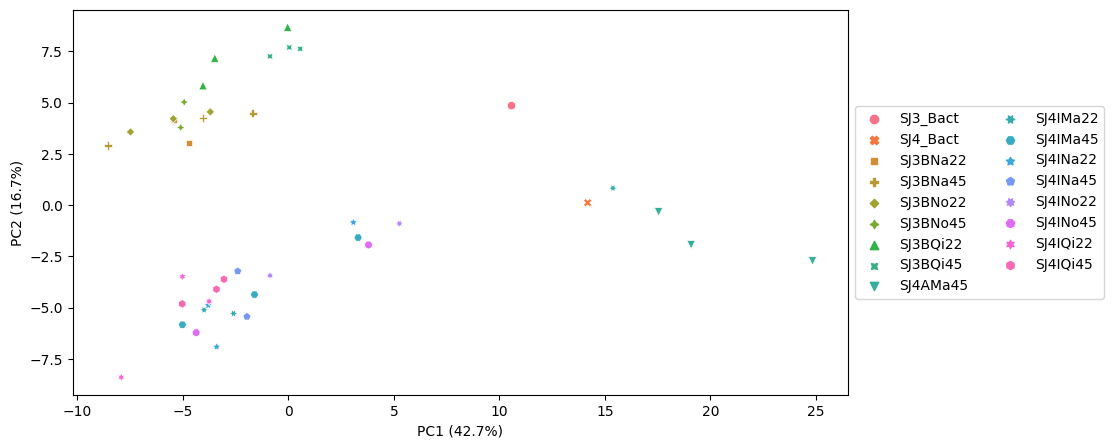

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
pc_df['SampleApproachMethodFilter'] = pc_df['Sample'] + pc_df['Approach'] + pc_df['Method'] + pc_df['Filter']
pc_df.at[0, 'SampleApproachMethodFilter'] = 'SJ3_Bact'
pc_df.at[1, 'SampleApproachMethodFilter'] = 'SJ4_Bact'

ax = sns.scatterplot(x="PC1", y="PC2", hue='SampleApproachMethodFilter', style='SampleApproachMethodFilter', legend=True, data=pc_df)
l = ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
l = ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
fig.savefig(f"sarah/pca_combined_replicates.png")